In [1]:
import mindspore
# 载入mindspore的默认数据集
import mindspore.dataset as ds
# 常用转化用算子
import mindspore.dataset.transforms.c_transforms as C
# 图像转化用算子
####____####
import mindspore.dataset.vision.c_transforms as CV
from mindspore.common import dtype as mstype
# mindspore的tensor
from mindspore import Tensor


# 各类网络层都在nn里面
import mindspore.nn as nn
# 参数初始化的方式

from mindspore.common.initializer import TruncatedNormal
# 设置mindspore运行的环境
from mindspore import context
# 引入训练时候会使用到回调函数，如checkpoint, lossMoniter
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
# 引入模型
from mindspore.train import Model
# 引入评估模型的包
from mindspore.nn.metrics import Accuracy

# numpy
import numpy as np
# 画图用
import matplotlib.pyplot as plt


####____####
# 下载数据相关的包
import os
import requests 
import zipfile


In [2]:
!wget https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com/ComputerVision/cifar10_mindspore.zip
!unzip cifar10_mindspore.zip



--2022-05-07 14:55:46--  https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com/ComputerVision/cifar10_mindspore.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 170441801 (163M) [application/zip]
Saving to: ‘cifar10_mindspore.zip’

cifar10_mindspore.z 100%[===================>] 162.55M   135MB/s    in 1.2s    

2022-05-07 14:55:48 (135 MB/s) - ‘cifar10_mindspore.zip’ saved [170441801/170441801]

Archive:  cifar10_mindspore.zip
   creating: data/
   creating: data/10-batches-bin/
  inflating: data/10-batches-bin/batches.meta.txt  
  inflating: data/10-batches-bin/data_batch_1.bin  
  inflating: data/10-batches-bin/data_batch_2.bin  
  inflating: data/10-batches-bin/data_batch_3.bin  
  inflating: data/10-batches-bin/d

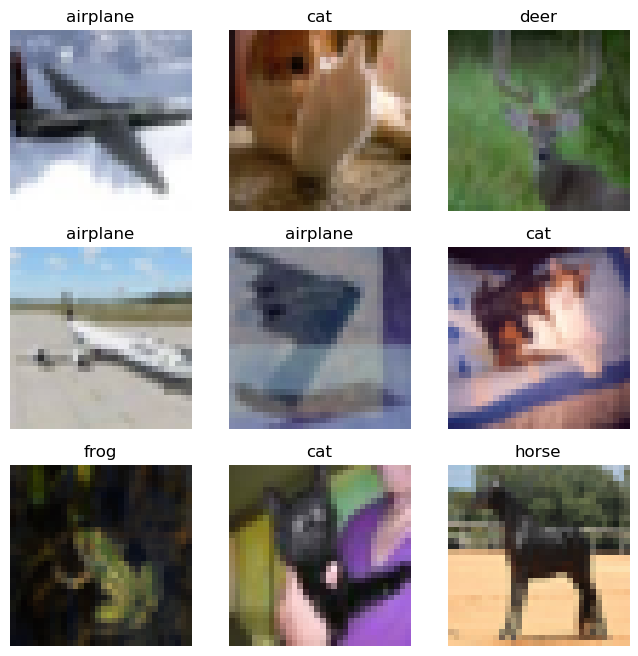

In [2]:
#创建图像标签列表
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
                 6:'frog',7:'horse',8:'ship',9:'truck'}

####____####
current_path = os.getcwd()
data_path = os.path.join(current_path, 'data/10-verify-bin')
cifar_ds = ds.Cifar10Dataset(data_path)

# 设置图像大小
plt.figure(figsize=(8,8))
i = 1
# 打印9张子图
for dic in cifar_ds.create_dict_iterator():
    plt.subplot(3,3,i)
    ####____####
    plt.imshow(dic['image'].asnumpy())
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().sum()])
    i +=1
    if i > 9 :
        break

plt.show()


In [3]:
def get_data(datapath):
    cifar_ds = ds.Cifar10Dataset(datapath)
    return cifar_ds

def process_dataset(cifar_ds,batch_size =32,status="train"):
    '''
    ---- 定义算子 ----
    '''
    # 归一化
    rescale = 1.0 / 255.0
    # 平移
    shift = 0.0

    resize_op = CV.Resize((32, 32))
    rescale_op = CV.Rescale(rescale, shift)
    # 对于RGB三通道分别设定mean和std
    normalize_op = CV.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    if status == "train":
        # 随机裁剪
        random_crop_op = CV.RandomCrop([32, 32], [4, 4, 4, 4])
        # 随机翻转
        random_horizontal_op = CV.RandomHorizontalFlip()
    # 通道变化
    channel_swap_op = CV.HWC2CHW()
    # 类型变化
    typecast_op = C.TypeCast(mstype.int32)

    '''
    ---- 算子运算 ----
    '''
    cifar_ds = cifar_ds.map(input_columns="label", operations=typecast_op)
    if status == "train":
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_crop_op)
        cifar_ds = cifar_ds.map(input_columns="image", operations=random_horizontal_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=resize_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=rescale_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=normalize_op)
    cifar_ds = cifar_ds.map(input_columns="image", operations=channel_swap_op)
    
    # shuffle
    cifar_ds = cifar_ds.shuffle(buffer_size=1000)
    # 切分数据集到batch_size
    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    
    return cifar_ds



In [4]:
data_path = os.path.join(current_path, 'data/10-batches-bin')
batch_size=32
status="train"

# 生成训练数据集
cifar_ds = get_data(data_path)
ds_train = process_dataset(cifar_ds,batch_size =batch_size, status=status)


In [5]:
"""LeNet."""


def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """weight initial for conv layer"""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="same")


def fc_with_initialize(input_channels, out_channels):
    """weight initial for fc layer"""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


def weight_variable():
    """weight initial"""
    return TruncatedNormal(0.02)


class LeNet5(nn.Cell):
    """
    Lenet network

    Args:
        num_class (int): Num classes. Default: 10.

    Returns:
        Tensor, output tensor
    Examples:
        >>> LeNet(num_class=10)

    """
    def __init__(self, num_class=10, channel=3):
        super(LeNet5, self).__init__()
        self.num_class = num_class
        self.conv1 = conv(channel, 6, 5)
        self.conv2 = conv(6, 16, 5)
        self.fc1 = fc_with_initialize(16 * 8 * 8, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, self.num_class)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
# 构建网络
network = LeNet5(10)


In [6]:
# 设置模型的设备与图的模式
context.set_context(mode=context.GRAPH_MODE)
# 使用交叉熵函数作为损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
# 优化器为Adam
net_opt = nn.Adam(params=network.trainable_params(), learning_rate=0.001)
# 监控每个epoch训练的时间
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())


In [7]:
from mindspore.train.callback import Callback

class EvalCallBack(Callback):
    def __init__(self, model, eval_dataset, eval_per_epoch, epoch_per_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.eval_per_epoch = eval_per_epoch
        self.epoch_per_eval = epoch_per_eval

    def epoch_end(self, run_context):
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        if cur_epoch % self.eval_per_epoch == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.epoch_per_eval["epoch"].append(cur_epoch)
            self.epoch_per_eval["acc"].append(acc["Accuracy"])
            print(acc)


In [8]:
# 设置CheckpointConfig，callback函数。save_checkpoint_steps=训练总数/batch_size
config_ck = CheckpointConfig(save_checkpoint_steps=1562,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet_original", directory='./results',config=config_ck)
# 建立可训练模型
model = Model(network = network, loss_fn=net_loss,optimizer=net_opt, metrics={"Accuracy": Accuracy()})
eval_per_epoch = 1
epoch_per_eval = {"epoch": [], "acc": []}
eval_cb = EvalCallBack(model, ds_train, eval_per_epoch, epoch_per_eval)
print("============== Starting Training ==============")
model.train(10, ds_train,callbacks=[ckpoint_cb, LossMonitor(per_print_times=1),eval_cb],dataset_sink_mode=True)



============== Starting Training ==============
epoch: 1 step: 1562, loss is 1.2886841
{'Accuracy': 0.42649647887323944}
epoch: 2 step: 1562, loss is 1.506368
{'Accuracy': 0.487916133162612}
epoch: 3 step: 1562, loss is 1.3492076
{'Accuracy': 0.5378321062740077}
epoch: 4 step: 1562, loss is 1.0628811
{'Accuracy': 0.5692621638924455}
epoch: 5 step: 1562, loss is 0.9176076
{'Accuracy': 0.5824063700384123}
epoch: 6 step: 1562, loss is 1.1651452
{'Accuracy': 0.59613076184379}
epoch: 7 step: 1562, loss is 0.8557693
{'Accuracy': 0.6060139244558259}
epoch: 8 step: 1562, loss is 1.384822
{'Accuracy': 0.6234395006402048}
epoch: 9 step: 1562, loss is 1.3780118
{'Accuracy': 0.6211387644046095}
epoch: 10 step: 1562, loss is 1.2512934
{'Accuracy': 0.6397847311139565}


In [9]:
data_path = os.path.join(current_path, 'data/10-verify-bin')
batch_size=32
status="test"
# 生成测试数据集
cifar_ds = ds.Cifar10Dataset(data_path)
ds_eval = process_dataset(cifar_ds,batch_size=batch_size,status=status)

res = model.eval(ds_eval, dataset_sink_mode=True)
# 评估测试集
print('test results:',res)


test results: {'Accuracy': 0.6533453525641025}


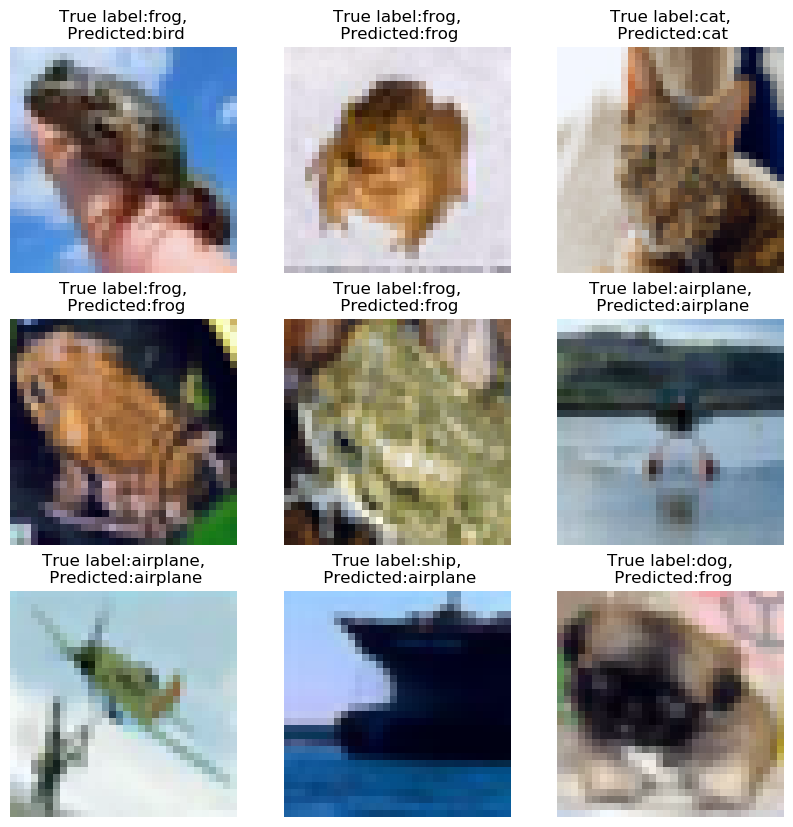

In [10]:
#创建图像标签列表
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
                 6:'frog',7:'horse',8:'ship',9:'truck'}

cifar_ds = get_data('./data/10-verify-bin')
df_test = process_dataset(cifar_ds,batch_size=1,status='test')

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

# 设置图像大小
plt.figure(figsize=(10,10))
i = 1
# 打印9张子图
for dic in df_test:
    # 预测单张图片
    input_img = dic[0]    
    output = model.predict(Tensor(input_img))
    output = nn.Softmax()(output)
    # 反馈可能性最大的类别
    predicted = np.argmax(output.asnumpy(),axis=1)[0]
    
    # 可视化
    plt.subplot(3,3,i)
    # 删除batch维度
    input_image = np.squeeze(input_img.asnumpy(),axis=0).transpose(1,2,0)
    # 重新归一化，方便可视化
    input_image = normalization(input_image)
    plt.imshow(input_image)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title('True label:%s,\n Predicted:%s'%(category_dict[dic[1].asnumpy().sum()],category_dict[predicted]))
    i +=1
    if i > 9 :
        break

plt.show()


In [11]:
class LeNet5_2(nn.Cell):
    """
    Lenet network
    

    Args:
        num_class (int): Num classes. Default: 10.

    Returns:
        Tensor, output tensor
    Examples:
        >>> LeNet(num_class=10)

    """
    def __init__(self, num_class=10, channel=3):
        super(LeNet5_2, self).__init__()
        self.num_class = num_class
        self.conv1_1 = conv(channel, 8, 3)
        self.bn2_1 = nn.BatchNorm2d(num_features=8)
        self.conv1_2 = conv(8, 16, 3)
        self.bn2_2 = nn.BatchNorm2d(num_features=16)        
        self.conv2_1 = conv(16, 32, 3)
        self.bn2_3 = nn.BatchNorm2d(num_features=32)        
        self.conv2_2 = conv(32, 64, 3)
        self.bn2_4 = nn.BatchNorm2d(num_features=64)
        self.fc1 = fc_with_initialize(64*8*8, 120)
        self.bn1_1 = nn.BatchNorm1d(num_features=120)
        self.fc2 = fc_with_initialize(120, 84)
        self.bn1_2 = nn.BatchNorm1d(num_features=84)
        self.fc3 = fc_with_initialize(84, self.num_class)
        self.relu = nn.ReLU()      
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        
        

    def construct(self, x):
        x = self.conv1_1(x)
        x = self.bn2_1(x)
        x = self.relu(x)
        x = self.conv1_2(x)
        x = self.bn2_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2_1(x)
        x = self.bn2_3(x)
        x = self.relu(x)
        x = self.conv2_2(x)
        x = self.bn2_4(x)
        x = self.relu(x)
        x = self.max_pool2d(x)        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1_1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn1_2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [12]:
ata_path = os.path.join(current_path, 'data/10-batches-bin')
batch_size=32
status="train"

# 生成训练数据集
cifar_ds = get_data(data_path)
ds_train = process_dataset(cifar_ds,batch_size =batch_size, status=status)
network = LeNet5_2(10)
#network = resnet50(10)
# 返回当前设备
device_target = mindspore.context.get_context('device_target')
# 确定图模型是否下沉到芯片上
dataset_sink_mode = True if device_target in ['Ascend','GPU'] else False
# 设置模型的设备与图的模式
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)
# 使用交叉熵函数作为损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
# 优化器为momentum
#net_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)
net_opt = nn.Adam(params=network.trainable_params(), learning_rate=0.001)
# 时间监控，反馈每个epoch的运行时间
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
# 设置callback函数。
config_ck = CheckpointConfig(save_checkpoint_steps=1562,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet_2_verified",directory='./results', config=config_ck)
# 建立可训练模型
model = Model(network = network, loss_fn=net_loss,optimizer=net_opt, metrics={"Accuracy": Accuracy()})
eval_per_epoch = 1
epoch_per_eval = {"epoch": [], "acc": []}
eval_cb = EvalCallBack(model, ds_train, eval_per_epoch, epoch_per_eval)
print("============== Starting Training ==============")

model.train(10, ds_train,callbacks=[ckpoint_cb, LossMonitor(per_print_times=1),eval_cb],dataset_sink_mode=True)


============== Starting Training ==============
epoch: 1 step: 312, loss is 1.3757281
{'Accuracy': 0.41035657051282054}
epoch: 2 step: 312, loss is 1.6983871
{'Accuracy': 0.48096955128205127}
epoch: 3 step: 312, loss is 1.2605116
{'Accuracy': 0.5295472756410257}
epoch: 4 step: 312, loss is 1.4025928
{'Accuracy': 0.5717147435897436}
epoch: 5 step: 312, loss is 1.2722797
{'Accuracy': 0.5925480769230769}
epoch: 6 step: 312, loss is 0.80949104
{'Accuracy': 0.6231971153846154}
epoch: 7 step: 312, loss is 1.1495345
{'Accuracy': 0.6412259615384616}
epoch: 8 step: 312, loss is 1.2073591
{'Accuracy': 0.6774839743589743}
epoch: 9 step: 312, loss is 0.7775886
{'Accuracy': 0.6851963141025641}
epoch: 10 step: 312, loss is 0.7166858
{'Accuracy': 0.7102363782051282}


In [13]:
data_path = os.path.join(current_path, 'data/10-verify-bin')
batch_size=32
status="test"
# 生成测试数据集
cifar_ds = ds.Cifar10Dataset(data_path)
ds_eval = process_dataset(cifar_ds,batch_size=batch_size,status=status)

res = model.eval(ds_eval, dataset_sink_mode=True)
# 评估测试集
print('test results:',res)


test results: {'Accuracy': 0.7504006410256411}


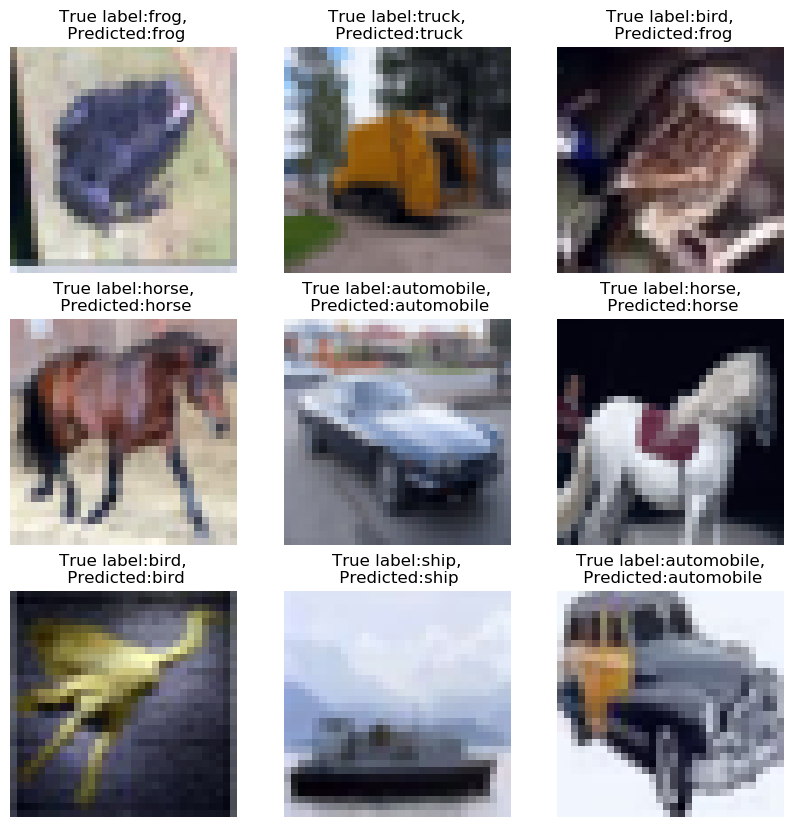

In [14]:
#创建图像标签列表
category_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',
                 6:'frog',7:'horse',8:'ship',9:'truck'}

cifar_ds = get_data('./data/10-verify-bin')
df_test = process_dataset(cifar_ds,batch_size=1,status='test')

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

# 设置图像大小
plt.figure(figsize=(10,10))
i = 1
# 打印9张子图
for dic in df_test:
    # 预测单张图片
    input_img = dic[0]    
    output = model.predict(Tensor(input_img))
    output = nn.Softmax()(output)
    # 反馈可能性最大的类别
    predicted = np.argmax(output.asnumpy(),axis=1)[0]
    
    # 可视化
    plt.subplot(3,3,i)
    # 删除batch维度
    input_image = np.squeeze(input_img.asnumpy(),axis=0).transpose(1,2,0)
    # 重新归一化，方便可视化
    input_image = normalization(input_image)
    plt.imshow(input_image)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title('True label:%s,\n Predicted:%s'%(category_dict[dic[1].asnumpy().sum()],category_dict[predicted]))
    i +=1
    if i > 9 :
        break

plt.show()
